In [ ]:
!pip install arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 22.1 MB/s eta 0:00:00


> "Initially, the data was cleaned on the local machine through multiple steps, including emoji removal, stripping open-ended question responses, and refining **the answers** using the **CAMeL-Lab/bert-base-arabic-camelbert-mix** (an AI model for spelling correction)."

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import font_manager
import matplotlib.font_manager as fm
from collections import Counter
import plotly.graph_objects as go
import plotly.colors as pc # Plotly colors module
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import random

### Data Phase

In [ ]:
df = pd.read_csv('/content/qa-data-ar.csv', encoding='utf-8-sig')

In [ ]:
df.describe()

,من أين تسمع أو تشاهد الأخبار؟,هل تعتقد أن الأخبار تؤثر على أحلامك؟ (أي أنك قد ترى كوابيس بسببها؟),هل تحب أن تعرف الأخبار عن الحرب أم تفضل عدم سماعها؟,عندما يخبرك شخص ما عن خبر، هل تصدقه دائمًا؟,كيف تشعر عندما تسمع أخبارًا عن الحرب؟,هل تخبر شخصًا آخر عندما تسمع خبرًا جديدًا؟,إذا طُلب منك رسم صورة لما تشعر به عند سماع الأخبار، ماذا سترسم؟,هل تفكر كثيرًا في الأخبار التي سمعتها عن الحرب حتى بعد مرور وقت عليها؟,ماذا تفعل عندما تسمع خبرًا يخيفك؟
count,75,75,75,75,75,75,75,75,75
unique,5,3,3,3,4,3,39,3,4
top,الهاتف (يوتيوب، واتساب، تيك توك),نعم، أرى أحيانًا كوابيس بسبب الأخبار,لا أحب سماع الأخبار لأنها تجعلني حزينًا أو خائفًا,نعم، أصدق كل ما أسمع,أشعر بالخوف أو الحزن,نعم، أخبر أصدقائي وعائلتي,طائره تستهدف الاطفال,نعم، أفكر فيها كثيرًا,أتحدث مع والدي أو معلمي
freq,39,50,33,38,28,35,8,30,26


In [ ]:
# First ensure clean data
print("\n" + "="*50)
print("UNIQUE VALUES PER COLUMN")
print("="*50 + "\n")

for col in df.columns:
    # Get unique values and handle NaN
    unique_vals = df[col].dropna().unique()

    # Clean string values
    if df[col].dtype == 'object':
        unique_vals = [str(v).strip() for v in unique_vals]

    # Display results
    print(f"➤ Column: {col}")
    print(f"   🔢 Number of unique values: {len(unique_vals)}")
    print(f"   📋 Unique values:", end=" ")

    # Print values in readable format
    if len(unique_vals) > 10:
        print('| '.join(map(str, unique_vals[:10])) + "...")
    else:
        print('| '.join(map(str, sorted(unique_vals))))

    print("-"*50 + "\n")


UNIQUE VALUES PER COLUMN

➤ Column: من أين تسمع أو تشاهد الأخبار؟
   🔢 Number of unique values: 5
   📋 Unique values: التلفاز| الهاتف (يوتيوب، واتساب، تيك توك)| في المدرسة أو من أصدقائي| لا أعرف| من عائلتي
--------------------------------------------------

➤ Column: هل تعتقد أن الأخبار تؤثر على أحلامك؟ (أي أنك قد ترى كوابيس بسببها؟)
   🔢 Number of unique values: 3
   📋 Unique values: لا أعرف| لا، لا أرى كوابيس بسبب الأخبار| نعم، أرى أحيانًا كوابيس بسبب الأخبار
--------------------------------------------------

➤ Column: هل تحب أن تعرف الأخبار عن الحرب أم تفضل عدم سماعها؟
   🔢 Number of unique values: 3
   📋 Unique values: أحب أن أعرف ما الذي يحدث| لا أحب سماع الأخبار لأنها تجعلني حزينًا أو خائفًا| لا يهمني الأمر
--------------------------------------------------

➤ Column: عندما يخبرك شخص ما عن خبر، هل تصدقه دائمًا؟
   🔢 Number of unique values: 3
   📋 Unique values: لا أعرف| لا، أحيانًا لا أصدق| نعم، أصدق كل ما أسمع
--------------------------------------------------

➤ Column: كيف 

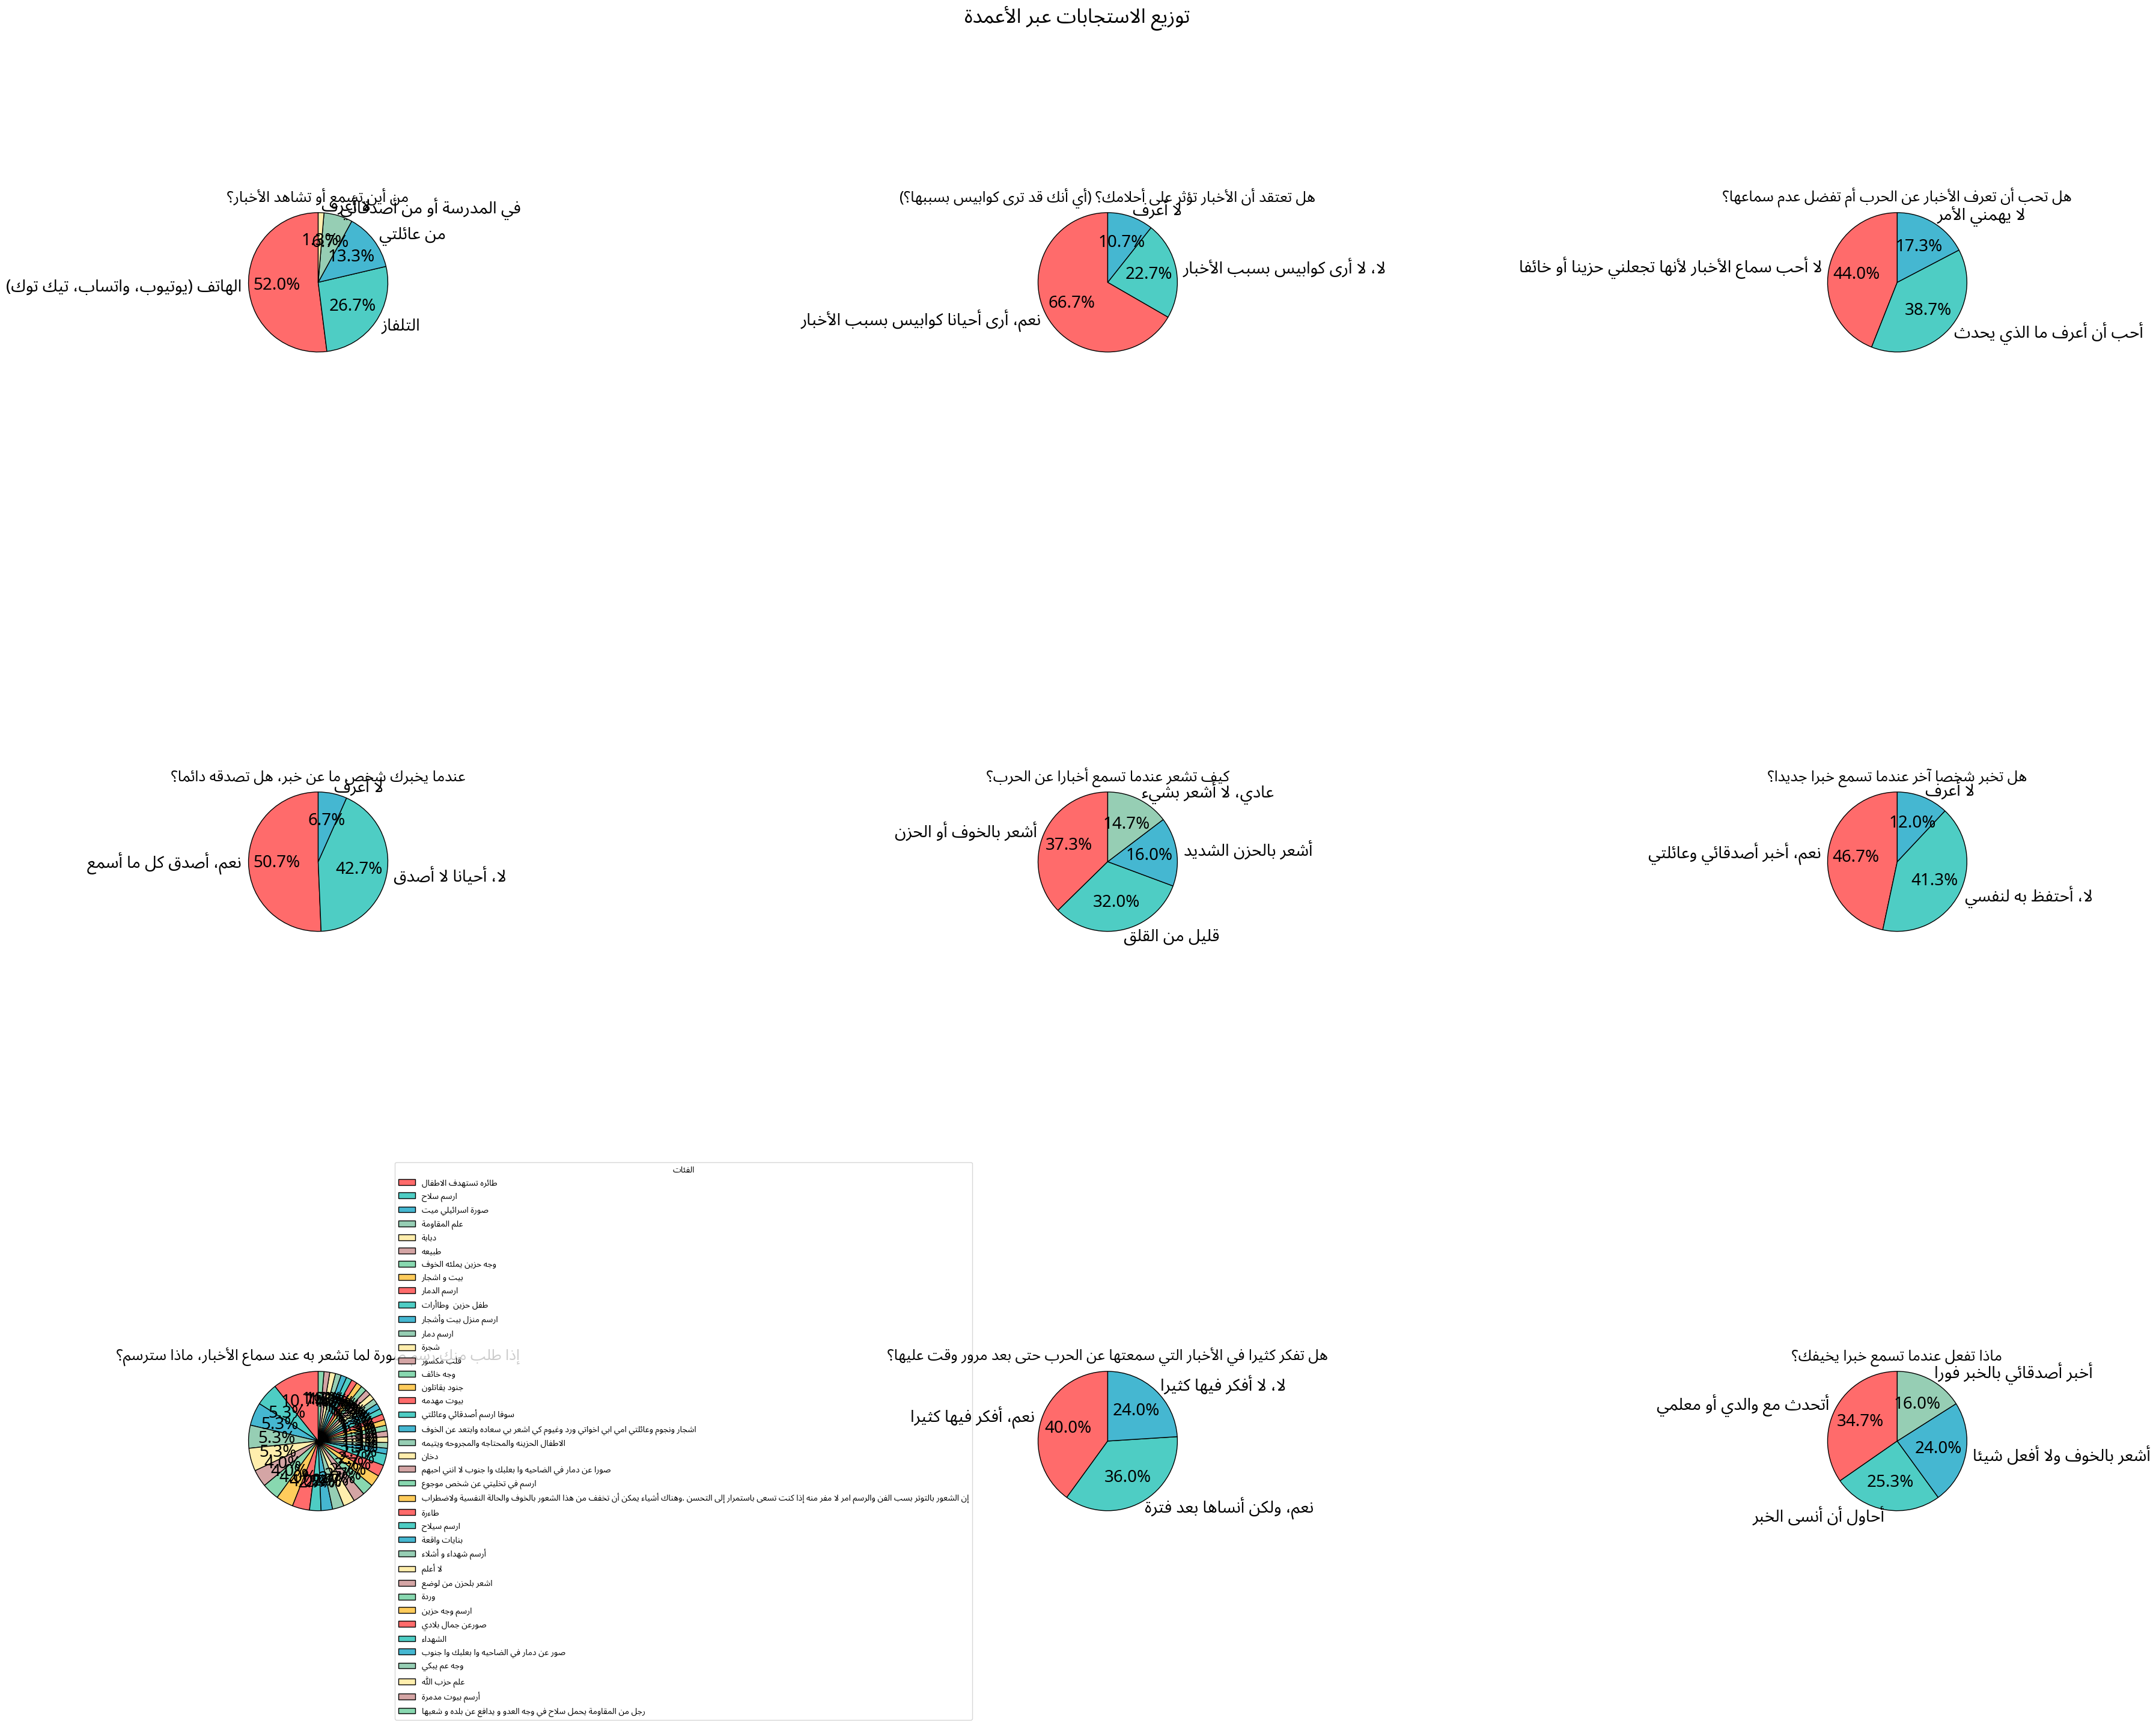

In [ ]:
# Register and set custom font (using your Noto Sans Arabic font)
font_path = '/content/NotoSansArabic-VariableFont_wdth,wght.ttf'
fm.fontManager.addfont(font_path)
custom_font = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = custom_font.get_name()

# Increase overall figure size (e.g., 35 x 30 inches)
fig, axes = plt.subplots(3, 3, figsize=(35, 30))

# Reshape and set the suptitle
suptitle_text = 'توزيع الاستجابات عبر الأعمدة'
reshaped_suptitle = get_display(arabic_reshaper.reshape(suptitle_text))
fig.suptitle(reshaped_suptitle, fontsize=24)

# Flatten axes for easy iteration
axes = axes.flatten()

# Custom colors palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD', '#D4A5A5', '#88D8B0', '#FFCC5C']

for idx, col in enumerate(df.columns):
    # Get value counts for each column
    counts = df[col].value_counts(dropna=True)

    # Create pie chart with an increased radius (larger chart within each subplot)
    wedges, texts, autotexts = axes[idx].pie(
        counts,
        labels=counts.index if len(counts) < 9 else None,  # Show labels only if categories are few
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 20},
        radius=1.2  # Increase the pie chart size within each subplot
    )

    # Reshape each text label for proper Arabic rendering
    for text in texts:
        reshaped = arabic_reshaper.reshape(text.get_text())
        bidi_text = get_display(reshaped)
        text.set_text(bidi_text)

    # Reshape and set the title for each subplot with increased font size and reduced padding
    reshaped_col = get_display(arabic_reshaper.reshape(col))
    axes[idx].set_title(reshaped_col, fontsize=18, pad=10)

    # If there are many categories, add a legend with reshaped text for Arabic
    if len(counts) >= 8:
        legend_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in counts.index]
        axes[idx].legend(
            legend_labels,
            title=get_display(arabic_reshaper.reshape('الفئات')),
            loc='center left',
            bbox_to_anchor=(1, 0.5)
        )

# Adjust layout with decreased padding between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout(rect=[0, 0, 1, 1])  # Reserve space for the suptitle

# plt.savefig('distribution_pie_charts.png', bbox_inches='tight', dpi=300)
plt.show()


### Sentiment Analysis

Now we will Use Sentiment Analysis model to evaluate how much the sentiment of the question "إذا طُلب منك رسم صورة لما تشعر به عند سماع الأخبار، ماذا سترسم؟"

In [ ]:
# Initialize the sentiment analysis pipeline
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
sentiment_analyzer = pipeline("text-classification", model=model_name)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
sentences = df['إذا طُلب منك رسم صورة لما تشعر به عند سماع الأخبار، ماذا سترسم؟']

In [ ]:
# unique values of sentences
sentences = [str(sentence).strip() for sentence in sentences]
unique_sentences = sentences
len(unique_sentences)

75

In [ ]:
# Run inference
results = sentiment_analyzer(unique_sentences)

In [ ]:
def decision(sentence, label, score):
    if label == "negative":
        return sentence, "negative", score

    if label == "neutral":
        return (sentence, "positive", score) if score > 0.9 else (sentence, "negative", score)

    if label == "positive":
        return (sentence, "positive", score) if score > 0.9 else (sentence, "negative", score)

In [ ]:
# Process results to get decisions
decisions = []
p = 0
n = 0
for sentence, result in zip(unique_sentences, results):
    # print(sentence, result)
    label = result['label']
    score = result['score']
    _, decision_label, decision_score = decision(sentence, label, score)
    if decision_label == "negative":
        n += 1
    else:
      p += 1
    decisions.append((decision_label, decision_score))
print(f"Positive: {p}, Negative: {n}")

Positive: 3, Negative: 72


In [ ]:
# Count frequencies of each sentence
sentence_counter = Counter(sentences)
top_sentences = sentence_counter.most_common(12)  # Get top 12 most frequent sentences

responses_str = f"Sentences (100%, {len(decisions)})"
# how much are positive
p_count = len(list(filter(lambda x: x[0] == 'positive', decisions)))
n_count = len(decisions) - p_count
# Create labels for the diagram
labels = [
    responses_str,    # Node 0
    f"Positive ({(p_count/len(decisions))*100:.1f}%, {p_count})",      # Node 1
    f"Negative ({(n_count/len(decisions))*100:.1f}%, {n_count})",      # Node 2
]

# Add labels for top sentences
for i, (sentence, freq) in enumerate(top_sentences):
    sentence_short = sentence[:30] + "..." if len(sentence) > 30 else sentence
    percentage = (freq / len(sentences)) * 100
    labels.append(f"{sentence_short} ({percentage:.1f}%, {freq})")

# Sources and Targets
sources = [
    0,  # Responses -> Positive
    0,  # Responses -> Negative
]
targets = [
    1,  # Responses -> Positive
    2,  # Responses -> Negative
]

# Add sources/targets for top sentences
for i in range(len(top_sentences)):
    # Determine if this sentence appears more in positive or negative category
    sentence = top_sentences[i][0]
    # Count occurrences with each sentiment
    pos_count = sum(1 for s, (label, _) in zip(sentences, decisions) if s == sentence and label == "positive")
    neg_count = sum(1 for s, (label, _) in zip(sentences, decisions) if s == sentence and label == "negative")

    # Connect to node with highest count
    if pos_count > neg_count:
        sources.append(1)  # From positive
    else:
        sources.append(2)  # From negative

    targets.append(i + 3)  # To sentence node (offset by 3 as first 3 nodes are fixed)

# Values (flow widths)
values = [
    p_count,  # Responses -> Positive
    n_count,  # Responses -> Negative
]

# Add values for top sentences
for i, (sentence, freq) in enumerate(top_sentences):
    pos_count = sum(1 for s, (label, _) in zip(sentences, decisions) if s == sentence and label == "positive")
    neg_count = sum(1 for s, (label, _) in zip(sentences, decisions) if s == sentence and label == "negative")

    # Add the appropriate count based on which node this sentence connects to
    if pos_count > neg_count:
        values.append(pos_count)
    else:
        values.append(neg_count)

# Create a Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,            # Space between nodes
        thickness=3,      # Node thickness
        line=dict(color="black", width=0.5),
        label=labels,      # Use your labels exactly
        color="lightblue"  # Node color (can be changed)
    ),
    link=dict(
        source=sources,    # List of sources
        target=targets,    # List of targets
        value=values,      # Flow values
        color=[
            "#90EE90" if src == 0 else "#FFCCCB"
            for src in sources
        ],  # Example color logic: if flow originates from node=1 (Positive) => green, else red
    )
)])

# Update layout with a title, figure size, and an annotation for the sentence
fig.update_layout(
    title_text="Children Sentiment Anaylsis",
    font=dict(size=14),
    width=600,   # Adjust figure width
    height=600,   # Adjust figure height
    annotations=[
        dict(
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10, color="black"),
            align="center"
        )
    ]
)

fig.show()

In [ ]:
# Data for the chart
labels = ['Positive', 'Negative']
counts = [p, n]
plotly_positive_color_scale = pc.sequential.Greens # Use Plotly's Greens sequential scale
plotly_negative_color_scale = pc.sequential.Reds   # Use Plotly's Reds sequential scale

# Get specific colors from the scales (e.g., around the middle for softer shades)
plotly_colors = [plotly_positive_color_scale[4], plotly_negative_color_scale[4]] # Index depends on the scale and desired shade


# --- Plotly Pie Chart ---
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=counts,
                             marker_colors=plotly_colors, # Apply smooth colors
                             hole=.3,                    # Add a donut hole for a more modern look (optional)
                             hoverinfo='label+percent', # Info to show on hover
                             textinfo='percent',         # Show percentages inside slices
                             textfont_size=12,
                             insidetextorientation='radial' # Orientation of percentage text
                            )])

# --- Plotly Layout for Title and Legend Styling ---
fig.update_layout(title_text='<b>Sentiment Analysis Results - Sentiment Distribution</b>', # Bold title
                  title_font_size=20,
                  legend=dict(
                      orientation="h",        # Horizontal legend
                      yanchor="bottom",
                      y=1.02,
                      xanchor="right",
                      x=1,
                      font=dict(size=12)      # Legend font size
                  ),
                  uniformtext_minsize=12, uniformtext_mode='hide', # Hide text if too small
                  margin=dict(l=20, r=20, t=60, b=20) # Adjust margins for better fit
                 )


fig.show()

### Word Cloud

In [ ]:
arabic_stopwords = set([
    "و", "في", "من", "هو", "هي", "على", "أن", "إلى", "عن", "مع",
    "ما", "أو", "هذا", "هذه", "ذلك", "هؤلاء", "كان", "يكون", "لا",
    "لم", "ليس", "إذا", "بين", "حتى", "عند", "بعض", "نحن", "هم", "كل",
    "كما", "له", "منذ", "قد", "أي", "إن", "إذ", "أيضا", "ب", "ت", "ث",
    "أن", "أنا", "إياك", "إليه", "لكن", "لن", "فى", "فيه", "قد",
    "قوة", "ك", "كل", "كما", "لك", "لم", "لما", "له", "ما", "مع",
    "مما", "من", "منه", "نحن", "هو", "هي", "يا", "عن", "إذ", "إذا",
    "هناك", "هذا", "هذه", "تلك", "أولئك", "أنت", "أنتم", "أنا", "إياي",
    "إياه", "أين", "أمام", "أمس", "أي", "أيضا", "أينما", "إليك", "إليكم",
    "علي", "عليك", "عليه", "ف", "فوق", "قبل", "قد", "كأن", "كأنما",
    "كذا", "كل", "كلا", "كلما", "كم", "كما", "كي", "كيف", "كيفما", "لأن",
    "لدى", "لذا", "لذلك", "لست", "لكي", "لكن", "له", "لهم", "لو", "متى",
    "مثل", "ماذا", "مما", "ممن", "منها", "نحو", "نعم", "هكذا", "هل",
    "هنا", "هناك", "وا", "وراء", "وفي", "وقد", "وكون", "ولا", "ولم", "وهو",
    "أف", "أقل", "أكثر", "ألا", "أم", "أما", "إن", "الآن", "اللهم", "اما",
    "ان", "اي", "بأن", "بين", "تحت", "تجاه", "حسب", "حول", "دون", "ذا",
    "رغم", "سوى", "شبه", "غير", "فان", "كذلك", "ل", "لعل", "لقد",
    "مذ", "ها", "وان", "وهم", "يلي","ارسم"
])

text = ""
for sentence in unique_sentences:
    words = sentence.split()  # Split sentence into words
    filtered_words = [word for word in words if word not in arabic_stopwords]  # Remove stopwords
    text += " ".join(filtered_words) + " "  # Reconstruct sentence

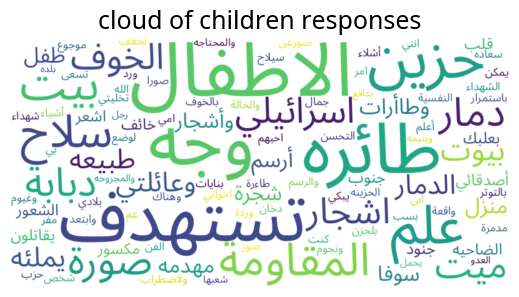

In [ ]:
prop = font_manager.FontProperties(fname=font_path)

# Function to properly handle Arabic text
def preprocess_arabic_text(text):
    return text
text = text.strip()

# Generate wordcloud directly with Arabic text
# The key is to let WordCloud handle the text with the right font
wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='white',
    prefer_horizontal=1.0,  # Force horizontal for Arabic
    collocations=False,
    min_font_size=14,
    max_font_size=120,
    relative_scaling=0.6,
    random_state=42,
    include_numbers=False,
    regexp=r"\w[\w']+",  # Handle Arabic words properly
).generate(text)

# Create figure for regular wordcloud
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# For the title, we DO need to apply reshaping and bidi
title_text = "cloud of children responses"

plt.title(title_text, fontproperties=prop, fontsize=18)

plt.tight_layout(pad=0)
plt.savefig('fixed_arabic_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()